In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl
import matplotlib.cm as cm

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
class NN(nn.Module):
    def __init__(self, lr, device = DEVICE):
        super().__init__()
        self.model = nn.Linear(2,1)
        
        self.update_optimizer(lr)
        self.loss_fn = nn.MSELoss()
        self.device = device
        self = self.to(self.device)
    
    def update_optimizer(self, lr):
        self.optimizer = torch.optim.SGD(self.parameters(), lr=lr)
    
    def forward(self, x):
        return self.model(x.to(self.device))
    
    def train(self, inputs, targets):
        self = self.to(self.device)
        pred = self(inputs.to(self.device))
        loss = self.loss_fn(pred, targets.to(self.device))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        print(loss.item())

class Generator(NN):
    def __init__(self, **kwargs):
        super().__init__(1e-2, **kwargs)
        self.model = nn.Sequential(nn.Linear(5,128),
                                   nn.LeakyReLU(.1),
                                   nn.Linear(128, 128),
                                   nn.LeakyReLU(.1),
                                   nn.Linear(128, 128),
                                   nn.LeakyReLU(.1),
                                   nn.Linear(128, 128),
                                   nn.LeakyReLU(.1),
                                   nn.Linear(128,2),
                                   nn.Tanh())
        
        self.update_optimizer(1e-2)
    
    def display(self, noise):
        fake = self(noise)
        if fake.get_device() == -1:
            fake_numpy = fake.detach().numpy()
        else:
            fake_numpy = fake.cpu().detach().numpy()
        return plt.scatter(fake_numpy[:,0], fake_numpy[:,1])
    
class Discriminator(NN):
    def __init__(self, **kwargs):
        super().__init__(1e-1, **kwargs)
        self.relu = nn.LeakyReLU(.1)
        
        #self.in_layer = nn.Linear(2,128)
        #self.out_layer = nn.Linear(128*2, 1)
        
        #self.layer1 = nn.Linear(128,128)
        #self.layer3 = nn.Linear(128*2,128)
        
        #self.layer2 = nn.Sequential(nn.Linear(128,16),
        #                            self.relu,
        #                            nn.Linear(16,128),
        #                            self.relu,
        #                            nn.Linear(128,128))
        
        self.in_layer = nn.Sequential(nn.Linear(2,128),
                                      self.relu,
                                      nn.Linear(128,128),
                                      self.relu,
                                      nn.Linear(128,128),
                                      self.relu,
                                      nn.Linear(128,128),
                                      self.relu,
                                      nn.Linear(128,128),
                                      self.relu,
                                      nn.Linear(128,128),
                                      self.relu,
                                      nn.Linear(128,128),
                                      self.relu,
                                      nn.Linear(128, 1))
        
        self.loss_fn = nn.BCELoss()
        self.update_optimizer(1e-1)
    
    def forward(self, x):
        out = self.relu(self.in_layer(x.to(self.device)))
        #out1 = self.relu(self.layer1(out))
        #out2 = self.relu(self.layer2(out1))
        #out3 = self.relu(self.layer3(torch.cat((out2, out1), 1)))
        #out = self.out_layer(torch.cat((out3, out), 1))
        return out
    
    def get_errors(self, inputs, targets):
        out = torch.sigmoid(self(inputs))
        out = out > .5
        print(f'Errors: {out[out != targets.to(self.device)].shape[0]}/{out.shape[0]}')
        
    def generate_field(self, steps=40):
        xs = torch.linspace(-1, 1, steps=steps)
        ys = torch.linspace(-1, 1, steps=steps)
        xs, ys = torch.meshgrid(xs, ys)
        points = torch.cat((xs.flatten().unsqueeze(1), ys.flatten().unsqueeze(1)), 1)
        out = torch.sigmoid(self(points.to(self.device)))
        return points, out
    
    def visualize(self, steps = 40):
        points, out = self.generate_field(steps)
        scat = plt.scatter(points[:, 0], points[:, 1], cmap='binary', c=(out>.5).detach().cpu(), marker='.', alpha=0.1)
        cb = plt.colorbar()
        return (scat, cb)

class GAN:
    def __init__(self, generator: nn.Module, discriminator: nn.Module):
        self.generator = generator
        self.discriminator = discriminator
        self.loss_fn = nn.BCELoss()
        self.optimizer_g = torch.optim.SGD(self.generator.parameters(), lr = 5e-3, maximize=True)
        self.optimizer_d = torch.optim.SGD(self.discriminator.parameters(), lr = 5e-3)
        self.verbose = True
        self.to(DEVICE)
        
    def set_lr(self, lr):
        self.optimizer_g.param_groups[0]['lr'] = lr
        self.optimizer_d.param_groups[0]['lr'] = lr
        
    def to(self, device):
        self.device = device
        self.generator = self.generator.to(device)
        self.discriminator = self.discriminator.to(device)
    
    def loss(self, pred, target):
        return self.loss_fn(pred, target)
    
    def predict(self, x):
        return torch.sigmoid(self.discriminator(x))
    
    # Updates both models
    def learn(self, pred, target):
        loss = self.loss(pred, target)
        self.optimizer_g.zero_grad()
        self.optimizer_d.zero_grad()
        loss.backward()
        self.optimizer_g.step()
        self.optimizer_d.step()
        if self.verbose:
            print(loss.item())
    
    # Train calls the learn function
    def train(self, real):
        # Update on fake data
        noise = torch.rand(real.shape[0], 5, device=self.device)
        fake = self.generator(noise)
        out = self.predict(fake)
        target = torch.zeros_like(out, device=self.device)
        self.learn(out, target)
        
        # Update on real data
        out = self.predict(real.to(self.device))
        target = torch.ones_like(out, device=self.device)
        self.learn(out, target)
        if self.verbose:
            print('******************')
    
    def animate_training(self, epochs, steps, real, fake):
        fig, ax = plt.subplots()
        number_frames = epochs // steps

        # Initialize the figure
        real_scat, fake_scat = self.display(noise, real)
        points_disc, out_disc = self.generate_disc_field(70)
        disc_scat = plt.scatter(points_disc[:, 0], points_disc[:, 1], cmap='binary', c=out_disc.detach().cpu(), marker='.', alpha=0.3)
        txt = plt.text(-1.1, 1.3, f'Epoch: {0}')

        def update(frame):
            for _ in range(steps):
                self.train(real)
            out_fake = self.generate_points(self.generator(noise.to(self.device)))
            out_real = self.generate_points(real)
            real_scat.set_offsets(out_real[:, :2])
            fake_scat.set_offsets(out_fake[:, :2])
            points_disc, out_disc = self.generate_disc_field(70)
            disc_scat.set_offsets(points_disc)

            norm = mpl.colors.Normalize(vmin=out_disc.min(), vmax=out_disc.max())
            cmap = cm.binary
            c = cm.ScalarMappable(norm=norm, cmap=cmap).to_rgba(out_disc.detach().cpu())
            disc_scat.set_color(c)

            txt.set_text(f'Epoch: {frame * steps}')

        return animation.FuncAnimation(fig=fig, func=update, frames=number_frames, interval=500)
    
    def save_animation(self, anim, filename, framerate = 60):
        print(f'Saving to {filename}')
        writervideo = animation.FFMpegWriter(fps=framerate)
        anim.save(f, writer=writervideo)
        print(f'Saved Successfully to {filename}')
    
    def generate_disc_field(self, steps=40):
        return self.discriminator.generate_field(steps)
        
    def visualize(self, steps=40):
        return self.discriminator.visualize(steps)
    
    def generate_points(self, data):
        data = data.to(self.device)
        out = self.predict(data)
        out = torch.cat((data, out), 1)

        if out.get_device() == -1:
            out = out.detach()
        else:
            out = out.cpu().detach()
        return out
            
    def display_fake(self, noise):
        fake = self.generator(noise.to(self.device))
        out = self.generate_points(fake)

        cmap = ['peachpuff' if pred < .5 else 'darkorange' for pred in out[:,2]]
        return plt.scatter(out[:,0], out[:,1], c=cmap)
    
    def display_real(self, real, true_color='lightblue', false_color='darkblue'):
        out = self.generate_points(real)

        cmap = [true_color if pred > .5 else false_color for pred in out[:,2]]
        return plt.scatter(out[:,0], out[:,1], c=cmap)
    
    def display(self, noise, real):
        real_scat = self.display_real(real)
        fake_scat = self.display_fake(noise)
        return (real_scat, fake_scat)
    
    def get_falses(self, real, noise):
        # Fake data
        fake = self.generator(noise.to(self.device))
        print(f'False positives:')
        targets = torch.zeros(fake.shape[0], 1, device=self.device)
        self.discriminator.get_errors(fake, targets)
        
        # Real data
        targets = torch.ones(real.shape[0], 1, device=self.device)
        print(f'False negatives:')
        self.discriminator.get_errors(real.to(self.device), targets)

In [3]:
# Double bar data
real1= torch.randn(500,2)
real2 = torch.randn(500,2)
real1[:, 0] *= 1e-1
real2[:, 0] *= 1e-1
real1[:, 0] -= .3
real2[:, 0] += .3
real1[:, 1] /= 5
real2[:, 1] /= 5
real1[:, 1] -= .2
real2[:, 1] += .2
real = torch.cat((real1, real2), 0)

In [5]:
# Round data
angles = 3 * torch.randn(1000,1)
real1 = torch.cos(angles) * (torch.rand(1000,1)*.3 + .5)
real2 = torch.sin(angles) * (torch.rand(1000,1)*.3 + .5)
real = torch.cat((real1, real2), 1)

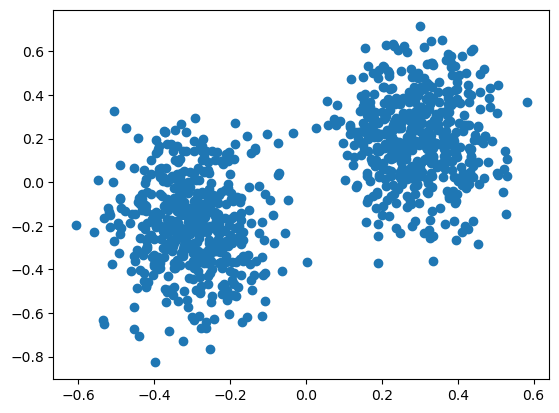

In [4]:
plt.scatter(real[:,0], real[:,1])

# Finding a performant enough discriminator

In [5]:
fake = torch.randn(500,2)
fake[:, 0] *= 2e-2
fake[:, 1] /= 5

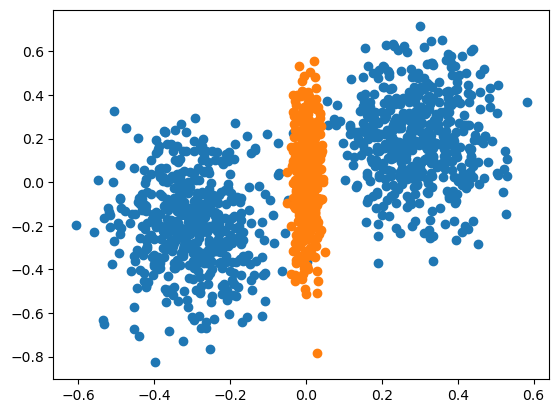

In [6]:
plt.scatter(real[:,0], real[:,1])
plt.scatter(fake[:,0], fake[:,1])

In [391]:
disc = Discriminator()

In [392]:
disc.update_optimizer(1e-1)

In [401]:
r = real

epochs = 1_000
for i in range(epochs):
    # Real data
    print('************\nReal data')
    targets = torch.ones(r.shape[0], 1)
    disc.train(r, targets)
    disc.get_errors(r, targets)
    
    # Fake data
    print('Fake data')
    targets = torch.zeros(fake.shape[0], 1)
    disc.train(fake, targets)
    disc.get_errors(fake, targets)

************
Real data
0.6941084265708923
Errors: 696/1000
Fake data
0.6904470920562744
Errors: 0/500
************
Real data
0.6941019892692566
Errors: 691/1000
Fake data
0.6904461979866028
Errors: 0/500
************
Real data
0.6940953731536865
Errors: 679/1000
Fake data
0.6904452443122864
Errors: 0/500
************
Real data
0.694088876247406
Errors: 672/1000
Fake data
0.6904441118240356
Errors: 0/500
************
Real data
0.6940823197364807
Errors: 664/1000
Fake data
0.6904430389404297
Errors: 0/500
************
Real data
0.6940758228302002
Errors: 656/1000
Fake data
0.690441906452179
Errors: 0/500
************
Real data
0.6940693855285645
Errors: 647/1000
Fake data
0.6904407143592834
Errors: 0/500
************
Real data
0.6940627694129944
Errors: 638/1000
Fake data
0.6904394626617432
Errors: 0/500
************
Real data
0.6940563321113586
Errors: 629/1000
Fake data
0.6904382705688477
Errors: 0/500
************
Real data
0.6940498352050781
Errors: 622/1000
Fake data
0.6904370188713

0.7317692041397095
Errors: 0/500
************
Real data
0.6783159375190735
Errors: 0/1000
Fake data
0.7266141772270203
Errors: 0/500
************
Real data
0.6810981631278992
Errors: 0/1000
Fake data
0.720456600189209
Errors: 0/500
************
Real data
0.6837822794914246
Errors: 0/1000
Fake data
0.693632960319519
Errors: 0/500
************
Real data
0.6705780625343323
Errors: 0/1000
Fake data
0.7290619015693665
Errors: 0/500
************
Real data
0.676671028137207
Errors: 0/1000
Fake data
0.7248296141624451
Errors: 0/500
************
Real data
0.6788569092750549
Errors: 0/1000
Fake data
0.7196676135063171
Errors: 0/500
************
Real data
0.6810380220413208
Errors: 0/1000
Fake data
0.6932393908500671
Errors: 2/500
************
Real data
0.6624445915222168
Errors: 0/1000
Fake data
0.7321036458015442
Errors: 0/500
************
Real data
0.6703884601593018
Errors: 0/1000
Fake data
0.7265081405639648
Errors: 0/500
************
Real data
0.6731545925140381
Errors: 0/1000
Fake data
0.7

0.6361487507820129
Errors: 0/500
************
Real data
0.004892854951322079
Errors: 0/1000
Fake data
0.6340844631195068
Errors: 0/500
************
Real data
0.004781170282512903
Errors: 0/1000
Fake data
0.6319471597671509
Errors: 0/500
************
Real data
0.004677403252571821
Errors: 0/1000
Fake data
0.6297314167022705
Errors: 0/500
************
Real data
0.004579245112836361
Errors: 0/1000
Fake data
0.6274368762969971
Errors: 0/500
************
Real data
0.00448622927069664
Errors: 0/1000
Fake data
0.6250582337379456
Errors: 0/500
************
Real data
0.0043982029892504215
Errors: 0/1000
Fake data
0.6225882768630981
Errors: 0/500
************
Real data
0.004317524377256632
Errors: 0/1000
Fake data
0.6200182437896729
Errors: 0/500
************
Real data
0.004244604613631964
Errors: 0/1000
Fake data
0.6173414587974548
Errors: 0/500
************
Real data
0.004179174546152353
Errors: 0/1000
Fake data
0.6145499348640442
Errors: 0/500
************
Real data
0.004121438134461641
Error

0.009638531133532524
Errors: 0/500
************
Real data
0.0003676970081869513
Errors: 0/1000
Fake data
0.009308317676186562
Errors: 0/500
************
Real data
0.00035595722147263587
Errors: 0/1000
Fake data
0.008995680138468742
Errors: 0/500
************
Real data
0.0003454567340668291
Errors: 0/1000
Fake data
0.00870047602802515
Errors: 0/500
************
Real data
0.0003348692844156176
Errors: 0/1000
Fake data
0.008420572616159916
Errors: 0/500
************
Real data
0.000325252884067595
Errors: 0/1000
Fake data
0.008155212737619877
Errors: 0/500
************
Real data
0.00031613415922038257
Errors: 0/1000
Fake data
0.007903716526925564
Errors: 0/500
************
Real data
0.0003072424733545631
Errors: 0/1000
Fake data
0.007664628326892853
Errors: 0/500
************
Real data
0.0002988681953866035
Errors: 0/1000
Fake data
0.007437155582010746
Errors: 0/500
************
Real data
0.000290946860332042
Errors: 0/1000
Fake data
0.0072209956124424934
Errors: 0/500
************
Real da

0.0016349016223102808
Errors: 0/500
************
Real data
7.116295455489308e-05
Errors: 0/1000
Fake data
0.0016182742547243834
Errors: 0/500
************
Real data
7.04862832208164e-05
Errors: 0/1000
Fake data
0.001601953525096178
Errors: 0/500
************
Real data
6.981055776122957e-05
Errors: 0/1000
Fake data
0.0015859160339459777
Errors: 0/500
************
Real data
6.914298865012825e-05
Errors: 0/1000
Fake data
0.0015701449010521173
Errors: 0/500
************
Real data
6.8497727625072e-05
Errors: 0/1000
Fake data
0.0015546566573902965
Errors: 0/500
************
Real data
6.785291770938784e-05
Errors: 0/1000
Fake data
0.001539423130452633
Errors: 0/500
************
Real data
6.722570105921477e-05
Errors: 0/1000
Fake data
0.00152445153798908
Errors: 0/500
************
Real data
6.660593498963863e-05
Errors: 0/1000
Fake data
0.0015097225550562143
Errors: 0/500
************
Real data
6.600247434107587e-05
Errors: 0/1000
Fake data
0.0014952524797990918
Errors: 0/500
************
Real

0.0007726221811026335
Errors: 0/500
************
Real data
3.481260864646174e-05
Errors: 0/1000
Fake data
0.0007681343704462051
Errors: 0/500
************
Real data
3.461712185526267e-05
Errors: 0/1000
Fake data
0.0007636912050656974
Errors: 0/500
************
Real data
3.4427426726324484e-05
Errors: 0/1000
Fake data
0.0007592938491143286
Errors: 0/500
************
Real data
3.423665839363821e-05
Errors: 0/1000
Fake data
0.0007549416623078287
Errors: 0/500
************
Real data
3.4047803637804464e-05
Errors: 0/1000
Fake data
0.0007506310357712209
Errors: 0/500
************
Real data
3.38661229761783e-05
Errors: 0/1000
Fake data
0.0007463656365871429
Errors: 0/500
************
Real data
3.3678472391329706e-05
Errors: 0/1000
Fake data
0.0007421454065479338
Errors: 0/500
************
Real data
3.349536200403236e-05
Errors: 0/1000
Fake data
0.0007379600428976119
Errors: 0/500
************
Real data
3.331811967655085e-05
Errors: 0/1000
Fake data
0.0007338199648074806
Errors: 0/500
********

Errors: 0/1000
Fake data
0.0004750252701342106
Errors: 0/500
************
Real data
2.1810952603118494e-05
Errors: 0/1000
Fake data
0.00047312554670497775
Errors: 0/500
************
Real data
2.172406493627932e-05
Errors: 0/1000
Fake data
0.0004712379304692149
Errors: 0/500
************
Real data
2.1643385480274446e-05
Errors: 0/1000
Fake data
0.00046936533180996776
Errors: 0/500
************
Real data
2.1558829757850617e-05
Errors: 0/1000
Fake data
0.00046750559704378247
Errors: 0/500
************
Real data
2.1476957044797018e-05
Errors: 0/1000
Fake data
0.0004656569508370012
Errors: 0/500
************
Real data
2.13964594877325e-05
Errors: 0/1000
Fake data
0.000463822390884161
Errors: 0/500
************
Real data
2.1314528567017987e-05
Errors: 0/1000
Fake data
0.00046199921052902937
Errors: 0/500
************
Real data
2.1234989617369138e-05
Errors: 0/1000
Fake data
0.0004601921536959708
Errors: 0/500
************
Real data
2.1155028662178665e-05
Errors: 0/1000
Fake data
0.0004583941

0.00033602150506339967
Errors: 0/500
************
Real data
1.56060832523508e-05
Errors: 0/1000
Fake data
0.0003349948674440384
Errors: 0/500
************
Real data
1.556077586428728e-05
Errors: 0/1000
Fake data
0.00033397419610992074
Errors: 0/500
************
Real data
1.551308378111571e-05
Errors: 0/1000
Fake data
0.00033295853063464165
Errors: 0/500
************
Real data
1.5466885088244453e-05
Errors: 0/1000
Fake data
0.00033194993739016354
Errors: 0/500
************
Real data
1.5421341231558472e-05
Errors: 0/1000
Fake data
0.0003309434687253088
Errors: 0/500
************
Real data
1.5376035662484355e-05
Errors: 0/1000
Fake data
0.0003299454692751169
Errors: 0/500
************
Real data
1.5331923350458965e-05
Errors: 0/1000
Fake data
0.0003289509331807494
Errors: 0/500
************
Real data
1.5286082998500206e-05
Errors: 0/1000
Fake data
0.00032796410960145295
Errors: 0/500
************
Real data
1.524054187029833e-05
Errors: 0/1000
Fake data
0.000326980312820524
Errors: 0/500
**

1.189945760415867e-05
Errors: 0/1000
Fake data
0.00025351656950078905
Errors: 0/500
************
Real data
1.1871051356138196e-05
Errors: 0/1000
Fake data
0.0002528966579120606
Errors: 0/500
************
Real data
1.1843601896543987e-05
Errors: 0/1000
Fake data
0.00025227994774468243
Errors: 0/500
************
Real data
1.1815494872280397e-05
Errors: 0/1000
Fake data
0.00025166524574160576
Errors: 0/500
************
Real data
1.1788042684202082e-05
Errors: 0/1000
Fake data
0.0002510518825147301
Errors: 0/500
************
Real data
1.1760054803744424e-05
Errors: 0/1000
Fake data
0.00025044282665476203
Errors: 0/500
************
Real data
1.1731472113751806e-05
Errors: 0/1000
Fake data
0.0002498353715054691
Errors: 0/500
************
Real data
1.1703961718012579e-05
Errors: 0/1000
Fake data
0.0002492321655154228
Errors: 0/500
************
Real data
1.1676274880301207e-05
Errors: 0/1000
Fake data
0.000248630327405408
Errors: 0/500
************
Real data
1.1647751307464205e-05
Errors: 0/10

0.00021306853159330785
Errors: 0/500
************
Real data
1.0025333722296637e-05
Errors: 0/1000
Fake data
0.00021261519577819854
Errors: 0/500
************
Real data
1.0003675015468616e-05
Errors: 0/1000
Fake data
0.0002121610305039212
Errors: 0/500
************
Real data
9.983508789446205e-06
Errors: 0/1000
Fake data
0.000211710314033553
Errors: 0/500
************
Real data
9.962625881598797e-06
Errors: 0/1000
Fake data
0.00021126352658029646
Errors: 0/500
************
Real data
9.9421595223248e-06
Errors: 0/1000
Fake data
0.00021081400336697698
Errors: 0/500
************
Real data
9.922829121933319e-06
Errors: 0/1000
Fake data
0.00021036880207248032
Errors: 0/500
************
Real data
9.901110388454981e-06
Errors: 0/1000
Fake data
0.00020992524514440447
Errors: 0/500
************
Real data
9.88112333288882e-06
Errors: 0/1000
Fake data
0.00020948192104697227
Errors: 0/500
************
Real data
9.861671969702002e-06
Errors: 0/1000
Fake data
0.00020904254051856697
Errors: 0/500
****

0.00017492247570771724
Errors: 0/500
************
Real data
8.276660992123652e-06
Errors: 0/1000
Fake data
0.00017460579692851752
Errors: 0/500
************
Real data
8.261390576080885e-06
Errors: 0/1000
Fake data
0.00017428769206162542
Errors: 0/500
************
Real data
8.247787263826467e-06
Errors: 0/1000
Fake data
0.00017397053306922317
Errors: 0/500
************
Real data
8.233349944930524e-06
Errors: 0/1000
Fake data
0.00017365539679303765
Errors: 0/500
************
Real data
8.219628398364875e-06
Errors: 0/1000
Fake data
0.0001733402896206826
Errors: 0/500
************
Real data
8.205131052818615e-06
Errors: 0/1000
Fake data
0.00017302586638834327
Errors: 0/500
************
Real data
8.190396329155192e-06
Errors: 0/1000
Fake data
0.00017271479009650648
Errors: 0/500
************
Real data
8.174529284588061e-06
Errors: 0/1000
Fake data
0.0001724031026242301
Errors: 0/500
************
Real data
8.160091965692118e-06
Errors: 0/1000
Fake data
0.00017209217185154557
Errors: 0/500
**

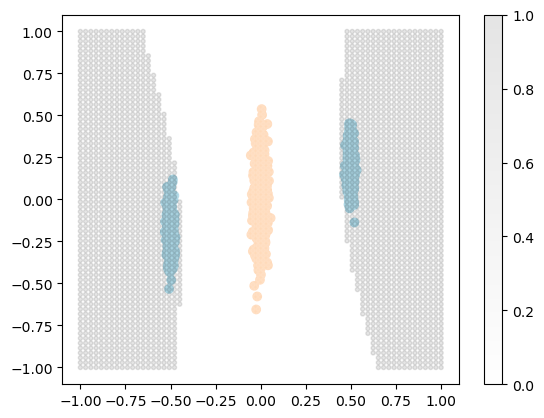

In [402]:
d = DEVICE
r = r.to(d)
out = disc(r)
out = torch.cat((r, out), 1)

if out.get_device() == -1:
    out = out.detach()
else:
    out = out.cpu().detach()

cmap = ['lightblue' if pred > .5 else 'darkblue' for pred in out[:,2]]
plt.scatter(out[:,0], out[:,1], c=cmap)

f = fake.to(d)
out = disc(f)
out = torch.cat((f, out), 1)

if out.get_device() == -1:
    out = out.detach()
else:
    out = out.cpu().detach()

cmap = ['peachpuff' if pred < .5 else 'darkorange' for pred in out[:,2]]
plt.scatter(out[:,0], out[:,1], c=cmap)
disc.visualize(steps=70)

# The GAN
We will use this architecture as we know it to be able to classify the data effectively.

Here is the distribution of the generator with NO training

In [19]:
gene = Generator()
disc = Discriminator()
gan = GAN(gene, disc)
gan.verbose = False

(<matplotlib.collections.PathCollection at 0x2309eef36d0>,
 <matplotlib.collections.PathCollection at 0x2309eef3c70>)

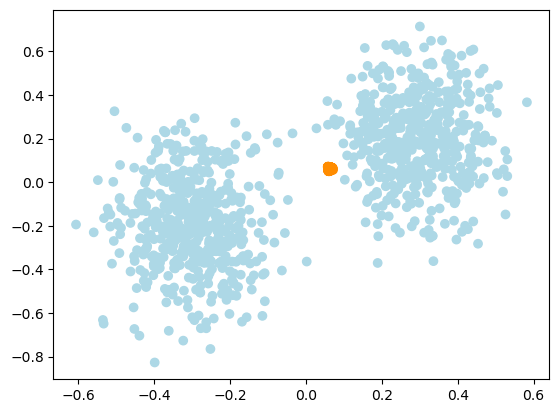

In [20]:
noise = torch.rand(1000, 5, device=DEVICE)
gan.display(noise, real)

Training

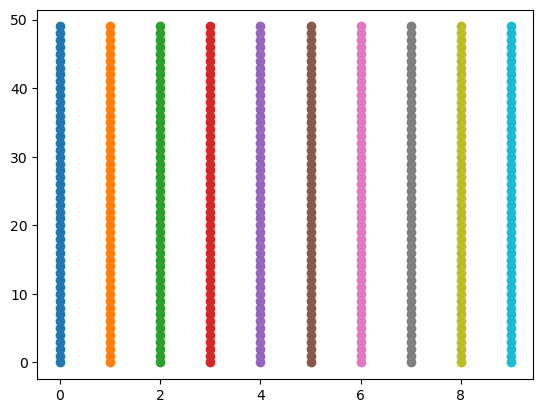

In [15]:
for i in range(10):
    nb = 50
    plt.plot([i]*nb,[x for x in range(nb)])
    plt.scatter([i]*nb,[x for x in range(nb)])

In [21]:
gan.set_lr(5e-2)

In [16]:
gan.verbose = False
epochs = 100_000
for i in range(epochs):
    gan.train(real)
gan.display(noise, real)
gan.get_falses(real, noise)
disc.visualize(steps=70)

KeyboardInterrupt: 

In [ ]:
f = r"E:\Github\machine-learning-practice\videos\gan.mp4"
gan.verbose = False
anim = gan.animate_training(100_000, 400, real, fake)
gan.save_animation(anim, f, framerate=24)

Saving to E:\Github\machine-learning-practice\videos\gan.mp4


## Conclusion

The regular GAN implementation diverged and will probably not converge unless we restart the training from scratch. This demonstrates the unstability of the setup.
We will investigate different setups that optimize and stabilize the process.

# Fixing the gradient issue
There is an issue in the magnitude of the gradients. Indeed, the loss function works perfectly for the discriminator, having large gradients when the error is high and smaller ones when the error is low.

However, the generator following a negative version of the discriminator loss, shows the same magnitude, making it hard for a generator to fight the discriminator when its error is low.

This is why we implement a different generator loss that yields larger gradients when the discriminator error is low, and smaller ones when it is high. This will balance the power between both models.

The different function is minimizing log(pred) instead of maximizing log(1-pred). A tip is to just **flip the targets** for the generator to automatically use the log(pred) section.

In [ ]:
class GAN_2(GAN):
    def __init__(self, gene, disc):
        super().__init__(gene, disc)
        # In this method, the generator battles the discriminator by having different targets
        # instead of maximizing the loss.
        self.optimizer_g.param_groups[0]['maximize'] = False
        
    def learn_d(self, pred, target):
        loss = self.loss_fn(pred, target)
        self.optimizer_d.zero_grad()
        loss.backward()
        self.optimizer_d.step()
        if self.verbose:
            print(loss.item())
            
    def learn_g(self, pred, target):
        loss = self.loss_fn(pred, target)
        self.optimizer_g.zero_grad()
        loss.backward()
        self.optimizer_g.step()
        if self.verbose:
            print(loss.item())
    
    def train(self, real):
        self.to(DEVICE)
        noise = torch.rand(real.shape[0], 5, device=self.device)
        
        # Update discriminator
        # On fake data
        fake = self.generator(noise)
        out = self.predict(fake)
        target = torch.zeros_like(out, device=self.device)
        self.learn_d(out, target)
        
        # On real data
        out = self.predict(real.to(self.device))
        target = torch.ones_like(out, device=self.device)
        self.learn_d(out, target)
        
        # Update the generator
        # On fake data
        fake = self.generator(noise)
        out = self.predict(fake)
        # HERE WE FLIP THE TARGETS
        target = torch.ones_like(out, device=self.device)
        self.learn_g(out, target)
        if self.verbose:
            print('******************')

In [ ]:
gene2 = Generator()
disc2 = Discriminator()
gan2 = GAN_2(gene2, disc2)
gan2.verbose = False

In [ ]:
noise = torch.rand(1000, 5, device=DEVICE)
gan2.display(noise, real)
disc2.visualize(70)

In [ ]:
gan2.set_lr(5e-2)

False positives:
Errors: 0/1000
False negatives:
Errors: 999/1000


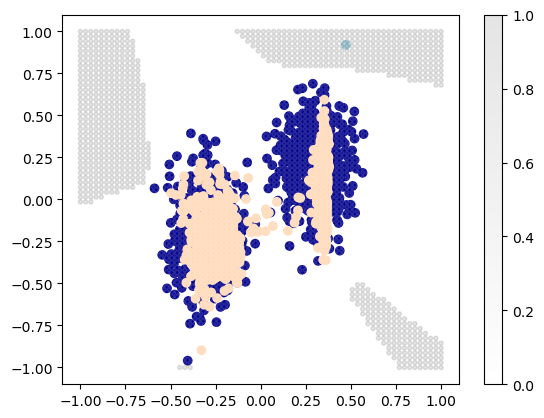

In [608]:
gan2.verbose = False
epochs = 100_000
for i in range(epochs):
    gan2.train(real)
gan2.display(noise, real)
gan2.get_falses(real, noise)
disc2.visualize(steps=70)

In [ ]:
f = r"E:\Github\machine-learning-practice\videos\gan2.mp4"
gan2.verbose = False
anim = gan2.animate_training(100_000, 400, real, fake)
gan2.save_animation(anim, f, framerate=24)

## Conclusion

By flipping the targets and optimizing the loss gradients for the generator, we managed to allow for the model to converge. This method improves the stability of the framework, especially compared to regular GANs.
However, the generator is still not perfectly copying the real distribution. The separation is enforced but one section of the distribution is not fully replicated.

# LSGAN

The loss function here is changed from binary cross-entropy to mse.

In [ ]:
class LSGAN(GAN):
    def __init__(self, gene, disc):
        super().__init__(gene, disc)
        self.optimizer_g.param_groups[0]['maximize'] = False
        self.loss_fn = nn.MSELoss()
        
    # This method sees a generator that fights with the discriminator
    # The loss function minimizes the loss with targets of fake data
    # being 0 for the discriminator and 1 for the generator.
    def train(self, real):
        noise = torch.rand(real.shape[0], 5, device=self.device)
        
        # Update the generator
        # On fake data
        fake = self.generator(noise)
        out = self.predict(fake)
        target = torch.ones_like(out)
        self.learn_g(out, target)
        
        # Update the discriminator
        # On fake data
        fake = self.generator(noise)
        out = self.predict(fake)
        target = torch.zeros_like(out, device=self.device)
        self.learn_d(out, target)
        # On real data
        out = self.predict(real.to(self.device))
        target = torch.ones_like(out, device=self.device)
        self.learn_d(out, target)
        if self.verbose:
            print('******************')
        
    def learn_g(self, pred, target):
        loss = self.loss(pred, target)
        self.optimizer_g.zero_grad()
        loss.backward()
        self.optimizer_g.step()
        if self.verbose:
            print(loss.item())
    
    def learn_d(self, pred, target):
        loss = self.loss(pred, target)
        self.optimizer_d.zero_grad()
        loss.backward()
        self.optimizer_d.step()
        if self.verbose:
            print(loss.item())

In [ ]:
gene_ls = Generator()
disc_ls = Discriminator()
lsgan = LSGAN(gene_ls, disc_ls)
lsgan.verbose = False

In [ ]:
noise = torch.rand(1000, 5)
lsgan.display(noise, real)
lsgan.discriminator.visualize(70)

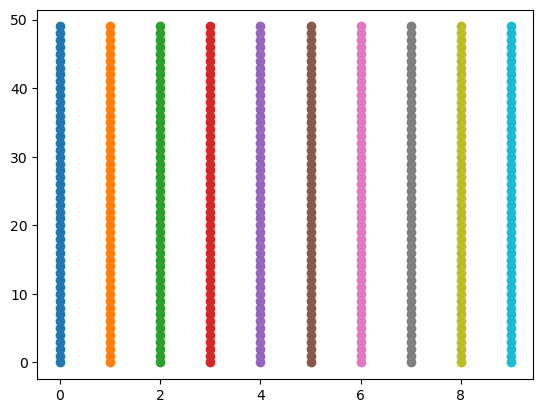

In [362]:
for i in range(10):
    nb = 50
    plt.plot([i]*nb,[x for x in range(nb)])
    plt.scatter([i]*nb,[x for x in range(nb)])

In [ ]:
lsgan.set_lr(5e-2)

False positives:
Errors: 897/1000
False negatives:
Errors: 15/1000


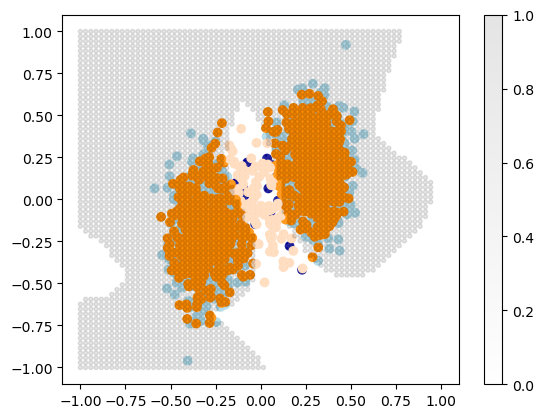

In [614]:
lsgan.verbose = False
epochs = 1_000
for i in range(epochs):
    lsgan.train(real)
lsgan.display(noise, real)
lsgan.get_falses(real, noise)
lsgan.discriminator.visualize(steps=70)

In [ ]:
f = r"E:\Github\machine-learning-practice\videos\lsgan.mp4"
lsgan.verbose = False
anim = lsgan.animate_training(100_000, 400, real, fake)
lsgan.save_animation(anim, f, framerate=24)

## Conclusion

By changing the loss function to mse, we enabled the model to converge.
Here, the generated distribution seems closer to the real distribution despite showing more elements in the separation area.

# Wasserstein GAN

2 major changes from regular GANs:
- The loss function is the difference of averages between real and fake images
- clamping the weights


In [ ]:
class Wasserstein_GAN(GAN):
    def __init__(self, generator: nn.Module, discriminator: nn.Module, weight_boundary = 1e-2, disc_iterations = 5):
        super().__init__(generator, discriminator)
        self.optimizer_g = torch.optim.RMSprop(self.generator.parameters(), lr = 5e-5)
        self.optimizer_d = torch.optim.RMSprop(self.discriminator.parameters(), lr = 5e-5)
        self.boundary = weight_boundary
        self.disc_iterations = disc_iterations
    
    def learn_d(self, pred_fake, pred_real):
        # The discriminator fights the generator by maximizing
        # the average difference between predictions on
        # fake and on real data.
        # Trick: Minimize the negation of the loss instead of maximizing.
        loss = -(torch.mean(pred_real) - torch.mean(pred_fake))
        self.optimizer_d.zero_grad()
        loss.backward()
        self.optimizer_d.step()
        # Clamp the weights.
        for p in self.discriminator.parameters():
            p.data.clamp_(-self.boundary, self.boundary)
        if self.verbose:
            print(f'Critic: {loss.item()}')
        return loss.item()
    
    def learn_g(self, pred_fake):
        # The generator loss minimizes the average difference
        # between predictions on fake and on real data.
        # The generator only affects the second half of the loss
        # function so we retain only this section in our calculations.
        loss = -torch.mean(pred_fake)
        self.optimizer_g.zero_grad()
        loss.backward()
        self.optimizer_g.step()
        if self.verbose:
            print(f'Generator: {loss.item()}')
        return loss.item()
    
    # Train calls the learn function
    def train(self, real):
        # Discriminator
        for _ in range(self.disc_iterations):
            noise = torch.rand(real.shape[0], 5, device=self.device)
            fake = self.generator(noise)
            out_fake = self.discriminator(fake)
            out_real = self.discriminator(real.to(self.device))
            self.learn_d(out_fake, out_real)
        
        # Generator
        noise = torch.rand(real.shape[0], 5, device=self.device)
        fake = self.generator(noise)
        out_fake = self.discriminator(fake)
        self.learn_g(out_fake)
        if self.verbose:
            print('******************')
            
    def generate_disc_field(self, steps=40):
        xs = torch.linspace(-1, 1, steps=steps)
        ys = torch.linspace(-1, 1, steps=steps)
        xs, ys = torch.meshgrid(xs, ys)
        points = torch.cat((xs.flatten().unsqueeze(1), ys.flatten().unsqueeze(1)), 1)
        out = self.discriminator(points)
        return points, out
    
    def visualize(self, steps = 40):
        points, out = self.generate_disc_field(steps)
        scat = plt.scatter(points[:, 0], points[:, 1], cmap='binary', c=out.detach().cpu(), marker='.', alpha=0.3)
        cb = plt.colorbar()
        return (scat, cb)
    
    def display_fake(self, noise):
        fake = self.generator(noise.to(self.device))
        out = self.generate_points(fake)

        return plt.scatter(out[:,0], out[:,1], color='peachpuff')
    
    def display_real(self, real):
        out = self.generate_points(real)

        return plt.scatter(out[:,0], out[:,1], color='lightblue')

In [ ]:
gene_w = Generator()
disc_w = Discriminator()
wgan = Wasserstein_GAN(gene_w, disc_w)

In [ ]:
noise = torch.rand(1000, 5)
wgan.display(noise, real)
wgan.visualize(70)

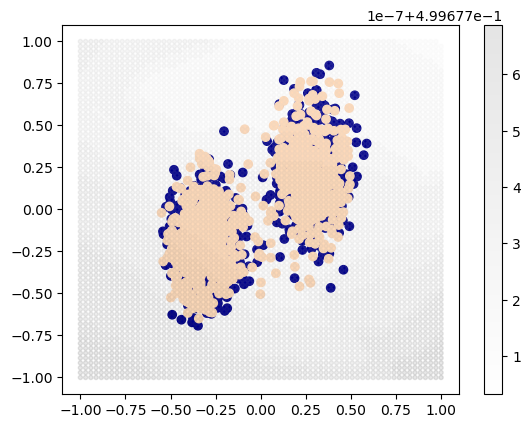

In [173]:
wgan.verbose = False
epochs = 100_000
for i in range(epochs):
    wgan.train(real)
wgan.display(noise, real)
wgan.visualize(steps=70)

In [ ]:
f = r"E:\Github\machine-learning-practice\videos\wgan.mp4"
wgan.verbose = False
anim = wgan.animate_training(1_000, 4, real, fake)
wgan.save_animation(anim, f, framerate=24)

## Hyperparameter investigation

Let's see the effect of various learning rates given some weight boundaries. Some combinations make the model diverge. We will try and understand the condition that makes it diverge.

In [223]:
# c = 1 sees a divergence quickly
c = 1e-1
gene_w2 = Generator()
disc_w2 = Discriminator()
wgan2 = Wasserstein_GAN(gene_w2, disc_w2, weight_boundary = c)

In [224]:
wgan2.set_lr(c*5e-3)

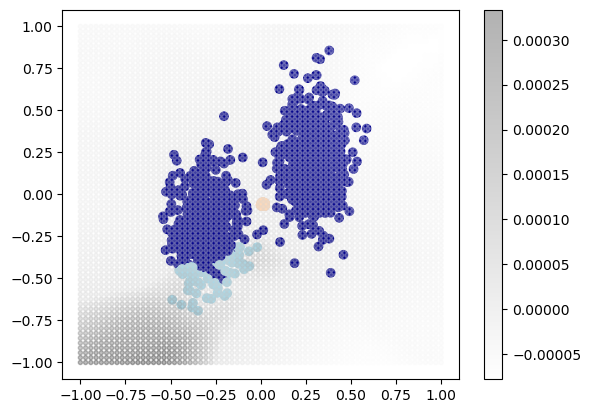

In [225]:
noise = torch.rand(1000, 5)
wgan2.display(noise, real)
wgan2.visualize(70)

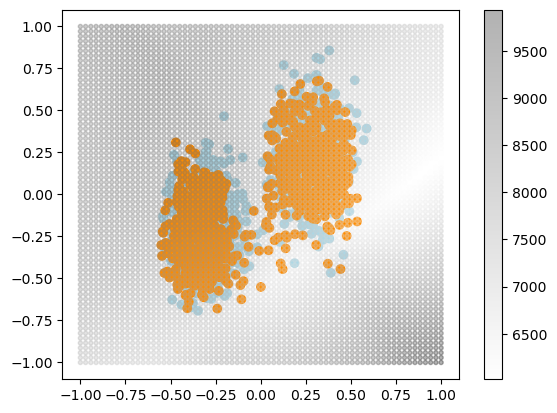

In [226]:
wgan2.verbose = False
epochs = 3_000
for i in range(epochs):
    wgan2.train(real)
wgan2.display(noise, real)
wgan2.visualize(steps=70)

## Gradient penalty

Instead of clamping the weights, another way to make a neural network 1-lipschitz is to add a gradient penalty that leads the weights naturally to converge to 1. This more natural and differentiable method is supposed to stailize training and convergence.

In [ ]:
class W_GAN_WP(Wasserstein_GAN):
    def __init__(self, generator: nn.Module, discriminator: nn.Module, lambda_gp = 10, disc_iterations = 5):
        super().__init__(generator, discriminator, disc_iterations = disc_iterations)
        self.lambda_gp = lambda_gp
        
        # Train calls the learn function
    def train(self, real):
        # Discriminator
        for _ in range(self.disc_iterations):
            noise = torch.rand(real.shape[0], 5, device=self.device)
            fake = self.generator(noise)
            out_fake = self.discriminator(fake)
            out_real = self.discriminator(real.to(self.device))
            gp = self.gradient_penalty(real.to(self.device), fake)
            self.learn_d(out_fake, out_real, gp)
        
        # Generator
        noise = torch.rand(real.shape[0], 5, device=self.device)
        fake = self.generator(noise)
        out_fake = self.discriminator(fake)
        self.learn_g(out_fake)
        if self.verbose:
            print('******************')
    
    def gradient_penalty(self, real, fake):
        epsilon = torch.rand((real.shape[0]))
        for _ in range(len(real.shape) - 1):
            epsilon = epsilon.unsqueeze(-1)
        epsilon = epsilon.repeat(1, *list(real.shape[1:])).to(self.device)
        interpolated_data = real * epsilon + fake * (1 - epsilon)
        
        pred = self.discriminator(interpolated_data)
        gradient = torch.autograd.grad(
            inputs = interpolated_data,
            outputs = pred,
            grad_outputs=torch.ones_like(pred),
            create_graph=True,
            retain_graph=True
            )[0]
        
        gradient = gradient.view(gradient.shape[0], -1)
        gradient_norm = gradient.norm(2, dim=1)
        gradient_penalty = torch.mean((gradient_norm-1)**2)
        return gradient_penalty
        
    def learn_d(self, pred_fake, pred_real, gp):
        # The discriminator fights the generator by maximizing
        # the average difference between predictions on
        # fake and on real data.
        # Trick: Minimize the negation of the loss instead of maximizing.
        loss = -(torch.mean(pred_real) - torch.mean(pred_fake)) + self.lambda_gp*gp
        self.optimizer_d.zero_grad()
        loss.backward()
        self.optimizer_d.step()
        
        if self.verbose:
            print(f'Critic: {loss.item()}')
        return loss.item()

In [ ]:
gene_w_wp = Generator()
disc_w_wp = Discriminator()
wgan_gp = W_GAN_WP(gene_w_wp, disc_w_wp)

In [ ]:
wgan_gp.lambda_gp = 1e-1
wgan_gp.set_lr(5e-4)

In [ ]:
noise = torch.rand(1000, 5)
wgan_gp.display(noise, real)
wgan_gp.visualize(70)

<IPython.core.display.Javascript object>


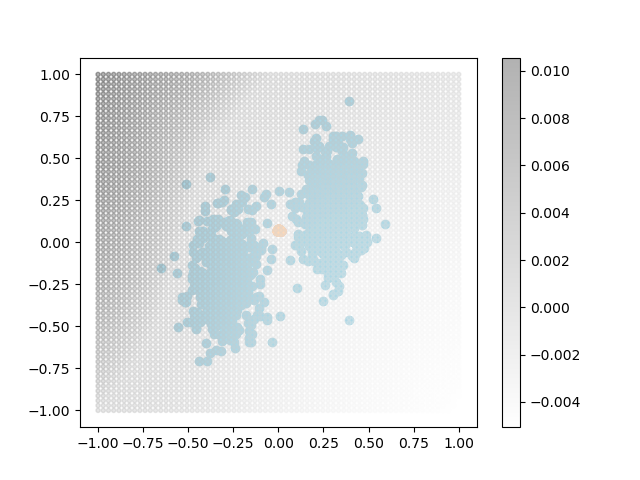

(<matplotlib.collections.PathCollection at 0x2751d2c6b60>,
 <matplotlib.colorbar.Colorbar at 0x2752b031420>)

In [48]:
wgan_gp.verbose = False
epochs = 100
for i in range(epochs):
    wgan_gp.train(real)
wgan_gp.display(noise, real)
wgan_gp.visualize(steps=70)

In [ ]:
f = r"E:\Github\machine-learning-practice\videos\wgan_gp.mp4"
wgan_gp.verbose = False
anim = wgan_gp.animate_training(24*6, 1, real, fake)
wgan_gp.save_animation(anim, f, framerate=24)

# Saving the video

<IPython.core.display.Javascript object>


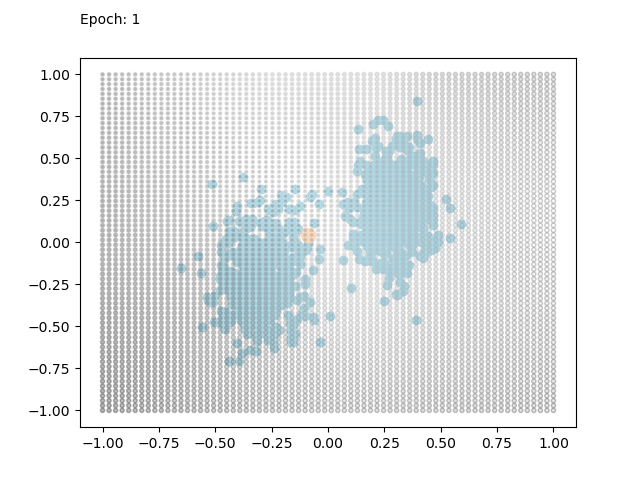

In [86]:
#%matplolib notebook
anim = wgan_gp.animate_training(24*6, 1, real, fake)